In [13]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import imageio
from scipy import ndimage
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

tf.keras.backend.set_floatx('float64')

In [36]:
def load_data(folder):
    available_classes = os.listdir(folder)
    data = []
    for img_class in available_classes:
        images = os.listdir(folder + '/' + img_class)
        for image in images:
            path = folder + '/' + img_class + '/' + image
            try:
                img = imageio.imread(path)
            except Exception as e:
                print(e)
                continue
            data.append((img.flatten() / 255., available_classes.index(img_class)))
    return data, available_classes

def remove_duplicates(train, val, test):
    index = {}
    for img, cls in val + test:
        if cls not in index:
            index[cls] = {}

        val_h = sum(img)
        if val_h not in index[cls]:
            index[cls][val_h] = []
        index[cls][val_h].append(img)
        
    duplicate_ids = []
    for i, img_cls in enumerate(train):
        img, cls = img_cls
        img = list(img)
        h = sum(img)
        if h in index[cls]:
            candidates = index[cls][h]
            for candidate in candidates:
                if list(candidate) == img:
                    duplicate_ids.append(i)
                    break
                
    for data_id in reversed(duplicate_ids):
        del train[data_id]
        
def unzip(tuples):
    first = [t[0] for t in tuples]
    second = [t[1] for t in tuples]
    return np.array(first), np.array(second)

In [15]:
large_mnist = "../Lab 1/notMNIST_large"
small_mnist = "../Lab 1/notMNIST_small"

In [16]:
data, available_classes = load_data(small_mnist)

Could not find a format to read the specified file in mode 'i'
Could not find a format to read the specified file in mode 'i'


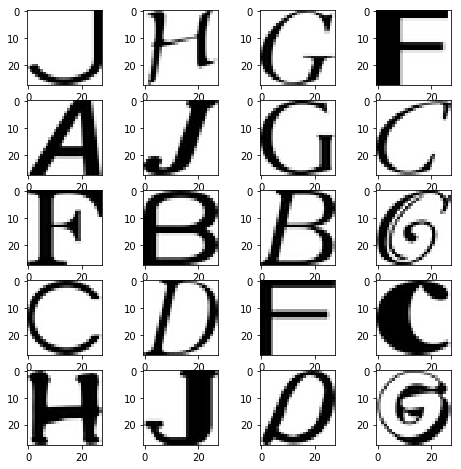

In [17]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img = random.choice(data)[0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.reshape(28, 28), interpolation='nearest', cmap='Greys')

plt.show()

In [25]:
import random

size = len(data)
train_size = int(size * 0.95)
val_size = int(train_size * 0.05)

random.shuffle(data)

train_data = data[:train_size]
test_data = data[train_size:]
val_data = train_data[:val_size]
train_data = train_data[val_size:]

In [28]:
remove_duplicates(train_data, val_data, test_data)

In [37]:
train_x, train_y = unzip(train_data)
val_x, val_y = unzip(val_data)
test_x, test_y = unzip(test_data)

In [53]:
from tensorflow.keras import layers, Model, Input, Sequential
from tensorflow.keras.layers import Dense, Dropout

num_classes = len(available_classes)

model = Sequential([
    Dense(784, activation="relu", input_shape=(784,)),
    Dense(250, activation="tanh"),
    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_25 (Dense)             (None, 250)               196250    
_________________________________________________________________
dense_26 (Dense)             (None, 10)                2510      
Total params: 814,200
Trainable params: 814,200
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(train_x, train_y, epochs=15, batch_size=32, validation_data=(val_x, val_y))

Train on 16616 samples, validate on 889 samples
Epoch 1/15
16616/16616 [==============================] - 3s 210us/sample - loss: 0.6938 - accuracy: 0.8272 - val_loss: 0.4393 - val_accuracy: 0.8841
Epoch 2/15
16616/16616 [==============================] - 3s 190us/sample - loss: 0.4220 - accuracy: 0.8864 - val_loss: 0.3978 - val_accuracy: 0.8830
Epoch 3/15
16616/16616 [==============================] - 3s 188us/sample - loss: 0.3766 - accuracy: 0.8987 - val_loss: 0.3612 - val_accuracy: 0.8965
Epoch 4/15
16616/16616 [==============================] - 3s 192us/sample - loss: 0.3484 - accuracy: 0.9039 - val_loss: 0.3498 - val_accuracy: 0.8999
Epoch 5/15
16616/16616 [==============================] - 3s 190us/sample - loss: 0.3283 - accuracy: 0.9086 - val_loss: 0.3469 - val_accuracy: 0.8999
Epoch 6/15
16616/16616 [==============================] - 3s 193us/sample - loss: 0.3104 - accuracy: 0.9151 - val_loss: 0.3788 - val_accuracy: 0.8943
Epoch 7/15
16616/16616 [============================

In [55]:
model.evaluate(test_x, test_y)

937/937 [==============================] - 0s 93us/sample - loss: 0.3542 - accuracy: 0.8933


[0.35418726171305154, 0.8932764140875133]

In [67]:
model = Sequential([
    Dense(784, activation="relu", input_shape=(784,)),
    Dropout(0.5),
    Dense(250, activation="tanh"),
    Dropout(0.5),
    Dense(250, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    Dense(100, activation="tanh"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_12 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 250)               196250    
_________________________________________________________________
dropout_13 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_50 (Dense)             (None, 100)               25100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)             

In [68]:
history = model.fit(train_x, train_y, epochs=20, batch_size=32, validation_data=(val_x, val_y))
model.evaluate(test_x, test_y)

Train on 16616 samples, validate on 889 samples
Epoch 1/20
16616/16616 [==============================] - 6s 372us/sample - loss: 2.9679 - accuracy: 0.7712 - val_loss: 0.5973 - val_accuracy: 0.8875
Epoch 2/20
16616/16616 [==============================] - 6s 339us/sample - loss: 0.6509 - accuracy: 0.8685 - val_loss: 0.5423 - val_accuracy: 0.9044
Epoch 3/20
16616/16616 [==============================] - 6s 340us/sample - loss: 0.5757 - accuracy: 0.8854 - val_loss: 0.5042 - val_accuracy: 0.8954
Epoch 4/20
16616/16616 [==============================] - 5s 330us/sample - loss: 0.5353 - accuracy: 0.8933 - val_loss: 0.4749 - val_accuracy: 0.9033
Epoch 5/20
16616/16616 [==============================] - 6s 335us/sample - loss: 0.4980 - accuracy: 0.8995 - val_loss: 0.4301 - val_accuracy: 0.9100
Epoch 6/20
16616/16616 [==============================] - 5s 327us/sample - loss: 0.4670 - accuracy: 0.9029 - val_loss: 0.4296 - val_accuracy: 0.9089
Epoch 7/20
16616/16616 [============================

[0.4115278367753615, 0.9103521878335112]

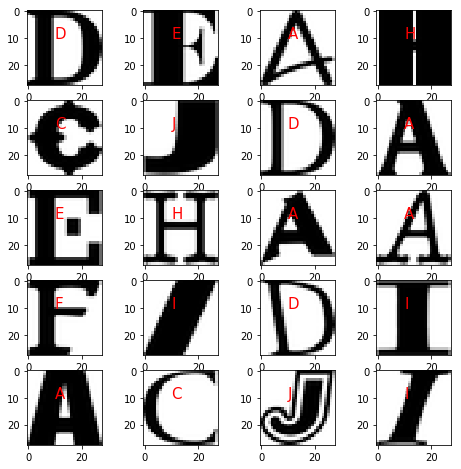

In [74]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img = random.choice(test_data)[0]
    prediction = np.argmax(model.predict(np.array([img]))[0])
    letter = available_classes[prediction]
    img = img.reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.text(10, 10, letter, color='red', fontsize=15)
    plt.imshow(img, interpolation='nearest', cmap='Greys')

plt.show()